In [1]:
import pickle
import cvxpy as cp
import pygmo as pg
from pygmo_plugins_nonfree import snopt7
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.reachsteering import MinFuel
from src.visualization import *
import src.lcvx as lc
%load_ext autoreload
%matplotlib inline

In [2]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

N = 60
tf = 60.0
alt = 1500.0
mass = 1800.0
x0 = np.array([0, 0, alt, -30.0, 0, -55.0, np.log(mass)])

lcvx = lc.LCvxMinFuel(
        rocket=lander,
        N=N,
        parameterize_x0=False,
        parameterize_tf=False,
        fixed_target=False,
    )
prob = lcvx.problem(x0=x0, tf=tf)
prob.solve(solver=cp.ECOS, verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 06 04:04:45 PM: Your problem has 667 variables, 250 constraints, and 0 parameters.
(CVXPY) Dec 06 04:04:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 04:04:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 04:04:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 06 04:04:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 04:04:46 PM: Compiling problem (target solver=ECOS).
(

281.3120327604892

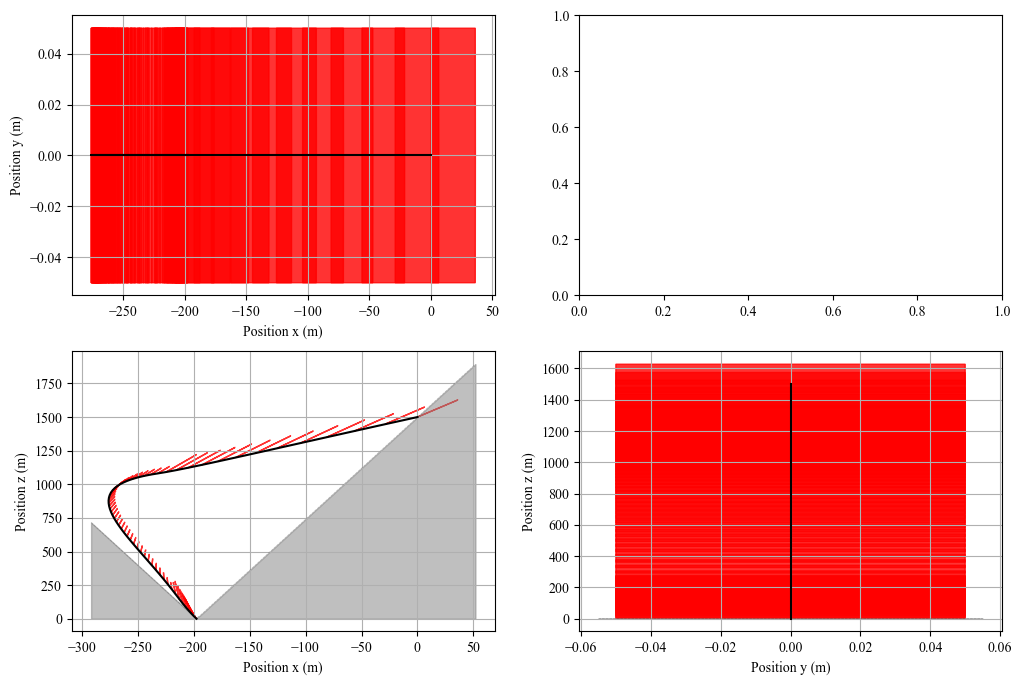

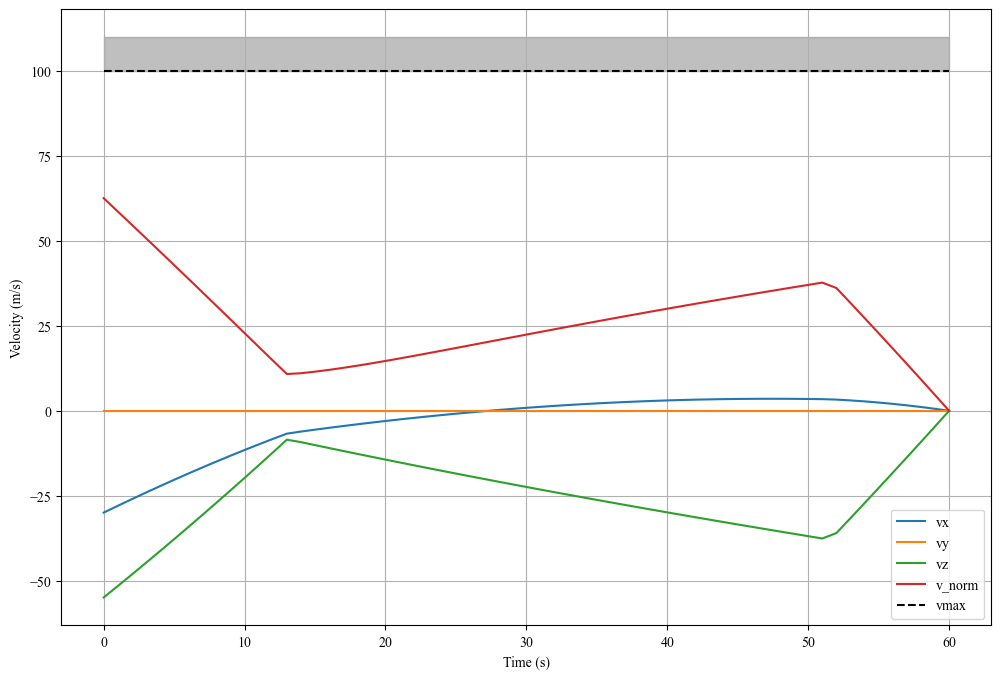

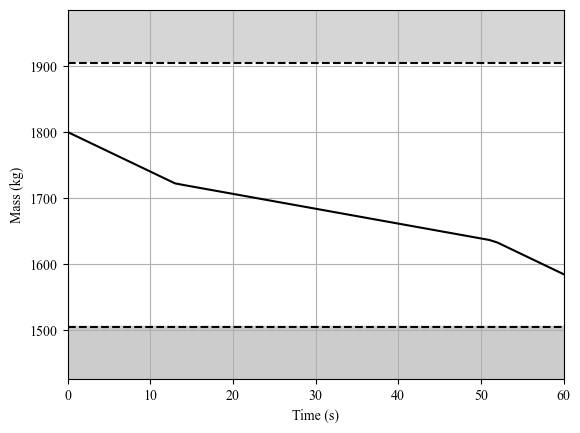

(60,)


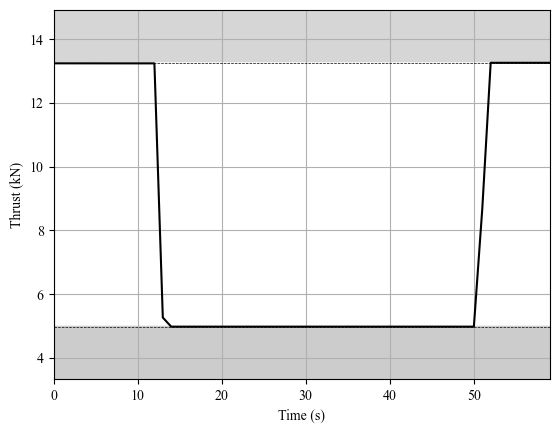

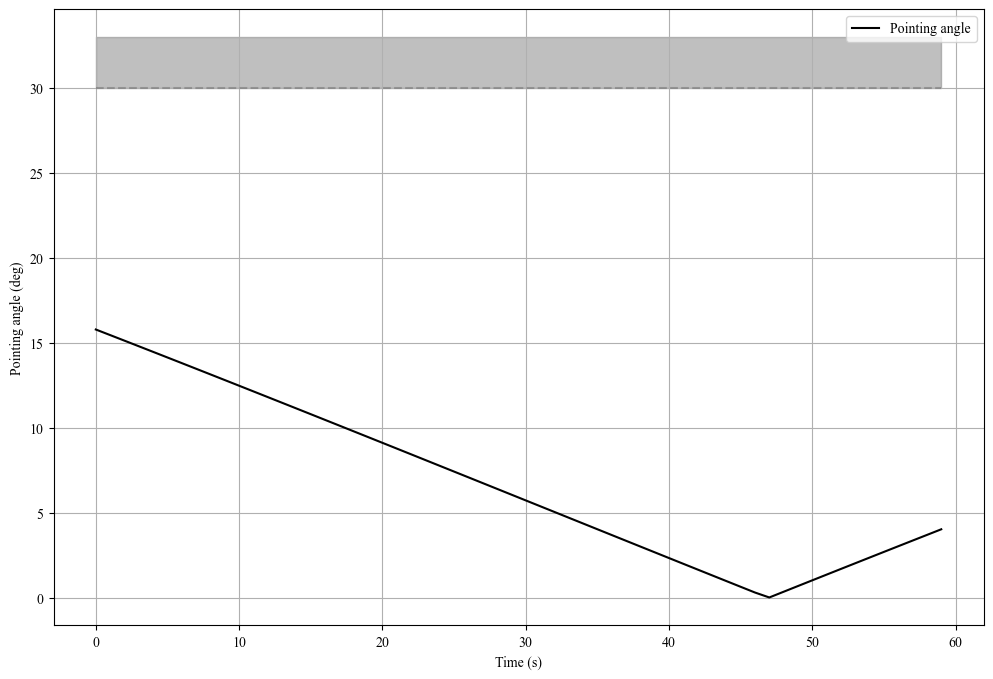

In [3]:
sol = lc.get_vars(prob, ["X", "U"])
X_sol = sol["X"]
U_sol = sol["U"]
r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)

# visualize
m = np.exp(z)
X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
U = u.T * m[:-1].reshape(-1, 1)

# Plot results
t = np.linspace(0, tf, lcvx.N + 1)
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)

plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)

In [4]:
prob = pg.problem(MinFuel(lander, N, x0, tf, False))

uda = snopt7(screen_output=False, library="C:/Users/ktomita3/libsnopt7/snopt7.dll", minor_version=7)
algo = pg.algorithm(uda)
algo.extract(snopt7).set_integer_option("Major Iteration Limit", 1000)
algo.extract(snopt7).set_numeric_option("Major feasibility tolerance", 1E-10)
algo.set_verbosity(1)

print(algo)

Algorithm name: SNOPT7 [deterministic]
	C++ class name: class pybind11::object

	Thread safety: none

Extra info:
	Name of the snopt7_c library: C:/Users/ktomita3/libsnopt7/snopt7.dll
	Library version declared: 7.7
	Screen output: (pagmo/pygmo) - verbosity 1
	Last optimisation return code: None
	Individual selection policy: best
	Individual replacement policy: best
	Integer options: {Major Iteration Limit : 1000}
	Numeric options: {Major feasibility tolerance : 1e-10}



In [8]:
pop = pg.population(prob, 1)
u_0 = U.flatten() / lander.rho2
#pop.set_x(0, u_0)

In [9]:
print(pop)

Problem name: <class 'src.reachsteering.problems.MinFuel'>
	C++ class name: class pybind11::object

	Global dimension:			180
	Integer dimension:			0
	Fitness dimension:			308
	Number of objectives:			1
	Equality constraints dimension:		4
	Inequality constraints dimension:	303
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [-1, -1, -1, -1, -1, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 55440
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1
	Gradient evaluations: 0

	Thread safety: none

Population size: 1

List of individuals: 
#0:
	ID:			17983795367833653146
	Decision vector:	[0.10257, -0.68244, 0.344372, 0.133514, 0.717225, ... ]
	Fitness vector:		[349.387, 0, 0, 0, 0, ... ]

Champion decision vector: [0.10257, -0.68244, 0.344372, 0.133514, 0.717225, ... ]
Champion fitness: [349.387, 0, 0, 0, 0, ... ]



In [10]:
result = algo.evolve(pop)

IndexError: invalid unordered_map<K, T> key

In [15]:
uda = snopt7(screen_output=False, library="SNOPT_DLL", minor_version=7)
algo = pg.algorithm(uda)
algo.set_verbosity(1)
prob = pg.problem(pg.cec2006(prob_id = 1))
prob.c_tol = [1e-6]*9
pop = pg.population(prob, 1)
algo.evolve()

TypeError: evolve(): incompatible function arguments. The following argument types are supported:
    1. (self: pygmo.core.algorithm, pop: pygmo.core.population) -> pygmo.core.population

Invoked with: Algorithm name: SNOPT7 [deterministic]
	C++ class name: class pybind11::object

	Thread safety: none

Extra info:
	Name of the snopt7_c library: C:/Users/ktomita3/libsnopt7/snopt7.dll
	Library version declared: 7.7
	Screen output: (pagmo/pygmo) - verbosity 1
	Last optimisation return code: None
	Individual selection policy: best
	Individual replacement policy: best


In [20]:
#uda = pg.nlopt(solver='cobyla')
#uda = pg.ipopt()
algo = pg.algorithm(uda)
#algo.set_verbosity(1)
#prob.c_tol = [1e-6] * (prob.get_nec() + prob.get_nic())
pop = pg.population(prob, 1)

u_0 = U.flatten() / lander.rho2
#u_0[u_0 < -1] = -1 + 1e-6
#u_0[u_0 > 1] = 1 - 1e-6
pop.set_x(0, u_0)

print(algo)
result = algo.evolve(pop)

Algorithm name: Ipopt: Interior Point Optimization [deterministic]
	C++ class name: class pagmo::ipopt

	Thread safety: none

Extra info:
	Last optimisation return code: Solve_Succeeded (value = 0)
	Verbosity: 0
	Individual selection policy: best
	Individual replacement policy: best



KeyboardInterrupt: 

In [9]:
U = result.champion_x.reshape(-1, 3) * lander.rho2
r, v, z = np.zeros((N + 1, 3)), np.zeros((N + 1, 3)), np.zeros(N + 1)
r[0] = x0[:3]
v[0] = x0[3:6]
z[0] = x0[6]
for i in range(N):
    r[i + 1], v[i + 1], z[i + 1] = prob._dynamics(r[i], v[i], z[i], U[i])

X = np.hstack((r, v, np.exp(z).reshape(-1, 1)))
# Plot results
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)

plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)


AttributeError: 'pygmo.core.problem' object has no attribute '_dynamics'

In [10]:
import math
class my_constrained_udp:
    def fitness(self, x):
        obj = 0
        for i in range(3):
            obj += (x[2*i-2]-3)**2 / 1000. - (x[2*i-2]-x[2*i-1]) + math.exp(20.*(x[2*i - 2]-x[2*i-1]))
        ce1 = 4*(x[0]-x[1])**2+x[1]-x[2]**2+x[2]-x[3]**2
        ce2 = 8*x[1]*(x[1]**2-x[0])-2*(1-x[1])+4*(x[1]-x[2])**2+x[0]**2+x[2]-x[3]**2+x[3]-x[4]**2
        ce3 = 8*x[2]*(x[2]**2-x[1])-2*(1-x[2])+4*(x[2]-x[3])**2+x[1]**2-x[0]+x[3]-x[4]**2+x[0]**2+x[4]-x[5]**2
        ce4 = 8*x[3]*(x[3]**2-x[2])-2*(1-x[3])+4*(x[3]-x[4])**2+x[2]**2-x[1]+x[4]-x[5]**2+x[1]**2+x[5]-x[0]
        ci1 = 8*x[4]*(x[4]**2-x[3])-2*(1-x[4])+4*(x[4]-x[5])**2+x[3]**2-x[2]+x[5]+x[2]**2-x[1]
        ci2 = -(8*x[5] * (x[5]**2-x[4])-2*(1-x[5]) +x[4]**2-x[3]+x[3]**2 - x[4])
        return [obj, ce1,ce2,ce3,ce4,ci1,ci2]
    def get_bounds(self):
        return ([-5]*6,[5]*6)
    def get_nic(self):
        return 2
    def get_nec(self):
        return 4
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [16]:
algo = pg.algorithm(uda = pg.nlopt('auglag'))
algo.extract(pg.nlopt).local_optimizer = pg.nlopt('var2')
algo.set_verbosity(200) # in this case this correspond to logs each 200 objevals
pop = pg.population(prob = my_constrained_udp(), size = 1)
pop.problem.c_tol = [1E-6] * 6
pop = algo.evolve(pop)


AttributeError: 'pygmo.core.population' object has no attribute 'get_fevals'